<a href="https://colab.research.google.com/github/speitzer/Climate-Model-Analysis/blob/main/turner_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path = r"/content/drive/My Drive/glamacles/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# get the sliding law and data from github
! git clone https://github.com/glamacles/nn_sliding_law

Cloning into 'nn_sliding_law'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 146 (delta 38), reused 131 (delta 31), pack-reused 0
Receiving objects: 100% (146/146), 4.18 MiB | 20.99 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [9]:
# import firedrake
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2024-06-23 14:52:44--  https://fem-on-colab.github.io/releases/firedrake-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4581 (4.5K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.47K  --.-KB/s    in 0s      

2024-06-23 14:52:44 (46.6 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4581/4581]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/9be49f2/rele

In [3]:
cd nn_sliding_law/examples/turner/inference

/content/nn_sliding_law/examples/turner/inference


In [4]:
run nn_law

  v_avg = np.nanmean(velocities,axis=0)

  warn(

  warn(



0 0.0008381459562897626 1.3767273426055908
172.62247487020161


Building the neural network. The next few cells are just practicing a single run-through of our pipeline.

In [5]:
# import nn dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# define the class, layers, and forward pass
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(4, 32),     # number of features, number of desired hidden layers
      nn.ReLU(),
      nn.Linear(32, 1)      # number of hidden layers, number of outputs
    )


  def forward(self, x):   # x = input
    '''Forward pass'''
    return self.layers(x)

In [13]:
# Initialize the MLP and run
mlp = MLP()   # initialize
log_beta = mlp(features) # feed the model with the features
beta = torch.exp(log_beta)  # take the exp of the NN output to ensure positivity
beta = beta.squeeze()

In [ ]:
# call the FE function with the NN computed beta
Ubar,Udef,H0 = fm.apply(H0,B,beta,adot,Ubar,Udef,model,adjoint,0.0,1e-5,solver_args)

0 0.22567097218261606 0.15775799751281738
1 0.1188677285428831 0.1786177158355713
2 0.06420111607956962 0.17967510223388672
3 0.0356700366322107 0.17386841773986816
4 0.020416013717743216 0.16799163818359375
5 0.012040751358401783 0.17979788780212402
6 0.007310712414660539 0.16690611839294434
7 0.004560848274736198 0.16721749305725098
8 0.002915624485003848 0.17133474349975586
9 0.0019040224431084857 0.1717066764831543
10 0.0012662519894342944 0.17167901992797852
11 0.0008551598197509697 0.17810702323913574


In [ ]:
# loss function
L = um.apply(Ubar,Udef,v_avg,v_tau,v_mask,ui)*750
print(L.item())

244.74799123212784


In [ ]:
# propogate back the loss
L.backward()

In [ ]:
# inspect the gradients from the NN
grads = [p.grad for p in mlp.parameters()]
grads

[tensor([[ 1.9816e+00,  1.1245e-01,  3.0870e+01,  4.1370e+01],
         [-6.4472e+00, -3.6543e-01, -1.0055e+02, -1.3475e+02],
         [-1.0965e-01, -4.3828e-02, -1.5983e+00, -6.8639e+00],
         [-9.1840e+00, -5.2113e-01, -1.4307e+02, -1.9173e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-8.2314e+00, -4.6712e-01, -1.2839e+02, -1.7205e+02],
         [ 8.8005e+00,  4.9937e-01,  1.3709e+02,  1.8372e+02],
         [-4.3327e-01, -1.7559e-01, -6.8725e+00, -2.6004e+01],
         [-6.8027e-01, -3.8763e-02, -1.0623e+01, -1.4261e+01],
         [ 2.4496e-02,  5.9178e-04,  4.5521e-01,  4.0468e-01],
         [ 8.9835e+00,  5.0919e-01,  1.4010e+02,  1.8776e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-5.6608e+00, -1.6232e-01, -8.8627e+01, -9.9751e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 8.3881e-01,  4.6244e-02,  1.3004e+01,  1.7418e+01],
         [-8.9041e+00, -5.0468e-01, -1.3887e+02, -1.861

Great. Now, we can loop this process, using the gradient in an optimizer to reduce our loss.

In [ ]:
U_file = df.File(f'{path}/nn/U_s.pvd')
loss_list = []
learning_rate = 0.01
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

for i in range(150):            # range= number of iterations
  log_beta = mlp(features)    # feed features in the initialized NN model
  beta = torch.exp(log_beta)  # take the exp of the NN output to ensure positivity
  beta = beta.squeeze()       # squeeze output to single dimension
  Ubar,Udef,H = fm.apply(H0,B,beta,adot,Ubar.detach(),Udef.detach(),model,adjoint,0.0,1e-5,solver_args)
  L = um.apply(Ubar,Udef,v_avg,v_tau,v_mask,ui)*750
  print(str(i)+": "+str(L.item()))
  loss_list.append(L.item())
  if i % 10 == 0:
    model.project_surface_velocity()
    U_file.write(model.U_s,time=i)

  L.backward()
  optimizer.step()
  optimizer.zero_grad()

  warn(



0: 172.3107698439203
1: 164.4262748872251
2: 162.93489854095318
3: 163.12168227285588
4: 163.5978683215832
5: 164.01167183430823
6: 164.29157744765317
7: 164.4491731030262
8: 164.48795369017296
9: 164.41539573426172
10: 164.2350563320501
11: 163.9513379880066
12: 163.5675550423109
13: 163.08726399482637
14: 162.5133671572142
15: 161.8666878060277
16: 161.1730792520435
17: 160.553404552562
18: 160.13394628584177
19: 160.08636108416167
20: 160.36685859289494
21: 160.4640087609043
22: 160.0485741330742
23: 159.28513786540938
24: 158.55754479196807
25: 158.03053686320303
26: 157.65731314784117
27: 157.3330667414619
28: 156.92124974601182
29: 156.3678595137512
30: 155.64144412464418
31: 154.81061759717943
32: 154.06078732108907
33: 153.52044871287234
34: 152.87521944673753
35: 151.83735924013448
36: 150.6020321648472
37: 149.49083624532204
38: 148.36178013362962
39: 146.80525705085904
40: 144.85082221034264
41: 142.99729765215025
42: 141.18030419644174
43: 138.65021184689795
44: 136.1200522

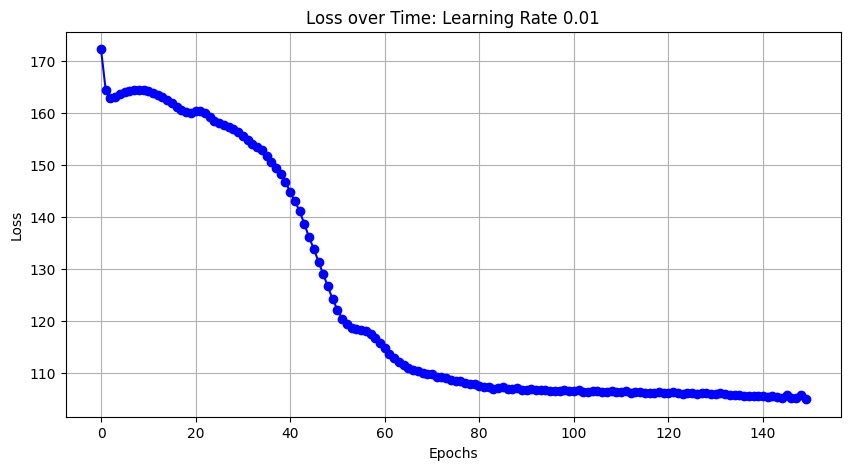

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss list
plt.figure(figsize=(10, 5))
plt.plot(loss_list, marker='o', linestyle='-', color='b')
plt.title('Loss over Time: Learning Rate '+ str(learning_rate))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


## Round 2: Varying input features and adding additional hidden layers to the NN.

Let's try changing up our input variables. Before, we used: bed, thickness, bed slope, and ice slope. This time, we'll include: thickness, melt, velocity, and bed slope.

In [20]:
#setup the new features
adot_f = df.project(model.adot,model.Q_cg1)

features2 = torch.vstack((
                          torch.tensor(adot_f.dat.data[:]),
                          torch.tensor(H_f.dat.data[:]),
                          torch.linalg.norm(torch.tensor(B_grad.dat.data[:]),axis=1),
                          torch.linalg.norm(Ubasal,axis=1)
                          )).T

In [36]:
# define the class, layers, and forward pass
class MLP2(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(4, 32),     # number of features, number of desired hidden layers
      nn.ReLU(),
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)      # number of hidden layers, number of outputs
    )


  def forward(self, x):   # x = input
    '''Forward pass'''
    return self.layers(x)


# Initialize the MLP and run
mlp2 = MLP2()   # initialize
U_file = df.File(f'{path}/nn2/U_s.pvd')
loss_list2 = []
learning_rate2 = 0.01
optimizer = torch.optim.Adam(mlp2.parameters(), lr=learning_rate2)

for i in range(100):            # range= number of iterations
  Ubar = Ubar.detach()
  Udef = Udef.detach()
  for j in range(5):
    Ubasal = uproject.apply(Ubar, Udef, ugrid)
    features2 = torch.vstack((
                          torch.tensor(adot_f.dat.data[:]),
                          torch.tensor(H_f.dat.data[:]),
                          torch.linalg.norm(torch.tensor(B_grad.dat.data[:]),axis=1),
                          torch.linalg.norm(Ubasal,axis=1)
                          )).T
    log_beta = mlp2(features2)  # feed features in the initialized NN model
    beta = torch.exp(log_beta)  # take the exp of the NN output to ensure positivity
    beta = beta.squeeze()       # squeeze output to single dimension
    print(str(i)+str(log_beta.mean()))
    Ubar,Udef,H = fm.apply(H0,B,beta,adot,Ubar.detach(),Udef.detach(),model,adjoint,0.0,1e-5,solver_args)
  L2 = um.apply(Ubar,Udef,v_avg,v_tau,v_mask,ui)*750
  print(str(i)+": "+str(L2.item()))
  loss_list2.append(L2.item())
  if i % 10 == 0:
    model.project_surface_velocity()
    U_file.write(model.U_s,time=i)

  L2.backward()
  optimizer.step()
  optimizer.zero_grad()

  warn(



0tensor(0.1275, grad_fn=<MeanBackward0>)
0 7.938046384632289e-05 0.1343214511871338
0tensor(0.1275, grad_fn=<MeanBackward0>)
0 1.1391105736744365e-05 0.169403076171875
0tensor(0.1275, grad_fn=<MeanBackward0>)
0 6.00855305541402e-06 0.1561431884765625
0tensor(0.1275, grad_fn=<MeanBackward0>)
0 3.3584283954677177e-06 0.15768933296203613
0tensor(0.1275, grad_fn=<MeanBackward0>)
0 1.941116498461147e-06 0.15932679176330566
0: 169.14992236302078
1tensor(-0.3565, grad_fn=<MeanBackward0>)
0 0.004134478376362905 0.12630367279052734
1 0.0022440625556643633 0.17850613594055176
2 0.0012286718569808237 0.16678476333618164
3 0.0007018439159221963 0.16605210304260254
1tensor(-0.3538, grad_fn=<MeanBackward0>)
0 0.00020695547728702413 0.1523144245147705
1tensor(-0.3538, grad_fn=<MeanBackward0>)
0 0.00011479758331699522 0.15229201316833496
1tensor(-0.3538, grad_fn=<MeanBackward0>)
0 6.455200683419711e-05 0.1577908992767334
1tensor(-0.3538, grad_fn=<MeanBackward0>)
0 3.679469013568269e-05 0.1636474132537

KeyboardInterrupt: 

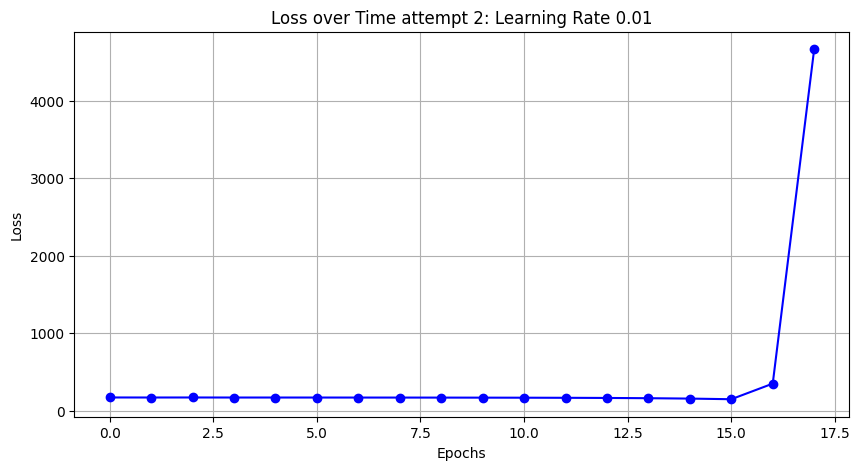

In [37]:
import matplotlib.pyplot as plt

# Plotting the loss list
plt.figure(figsize=(10, 5))
plt.plot(loss_list2, marker='o', linestyle='-', color='b')
plt.title('Loss over Time attempt 2: Learning Rate '+ str(learning_rate2))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


The model blows up or varies sporadically..

## Round 3. Remove velocity, add back other variables.

In [11]:
# define new feature
adot_f = df.project(model.adot,model.Q_cg1)

# define the class, layers, and forward pass
class MLP3(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(5, 30),     # number of features, number of desired hidden layers
      nn.ReLU(),
      nn.Linear(30, 55),
      nn.ReLU(),
      nn.Linear(55, 1)      # number of hidden layers, number of outputs
    )


  def forward(self, x):   # x = input
    '''Forward pass'''
    return self.layers(x)


# Initialize the MLP and run
mlp3 = MLP3()   # initialize
U_file = df.File(f'{path}/nn3/U_s.pvd')
loss_list3 = []
learning_rate3 = 0.01
optimizer = torch.optim.Adam(mlp3.parameters(), lr=learning_rate3)
features3 = torch.vstack((
                          torch.tensor(adot_f.dat.data[:]),
                          torch.tensor(H_f.dat.data[:]),
                          torch.tensor(B_f.dat.data[:]),
                          torch.linalg.norm(torch.tensor(B_grad.dat.data[:]),axis=1),
                          torch.linalg.norm(torch.tensor(S_grad.dat.data[:]),axis=1)
                          )).T

for i in range(200):            # range= number of iterations
  log_beta = mlp3(features3)    # feed features in the initialized NN model
  beta = torch.exp(log_beta)    # take the exp of the NN output to ensure positivity
  beta = beta.squeeze()         # squeeze output to single dimension
  Ubar,Udef,H = fm.apply(H0,B,beta,adot,Ubar.detach(),Udef.detach(),model,adjoint,0.0,1e-5,solver_args)
  L3 = um.apply(Ubar,Udef,v_avg,v_tau,v_mask,ui)*750
  print(str(i)+": "+str(L3.item()))
  loss_list3.append(L3.item())
  if i % 10 == 0:
    model.project_surface_velocity()
    U_file.write(model.U_s,time=i)

  L3.backward()
  optimizer.step()
  optimizer.zero_grad()

  warn(



0 0.09502380828547632 0.1528172492980957
1 0.04761191024500021 0.17260122299194336
2 0.02387584963535248 0.17589092254638672
3 0.011987687811068773 0.16599535942077637
4 0.006029164314625736 0.1835942268371582
5 0.0030385091444635236 0.16833734512329102
6 0.0015346411451355754 0.18151140213012695
7 0.0007771049741113732 0.16322803497314453
0: 169.1582931946915
0 0.00817917013202338 0.1472456455230713
1 0.0042279731830384745 0.1709744930267334
2 0.002221965480989796 0.16540217399597168
3 0.0011923356728745955 0.16296029090881348
4 0.0006570193010850735 0.16500377655029297
1: 168.72448621286534
0 0.001580525211548861 0.12554311752319336
1 0.0008631728544617728 0.1882014274597168
2: 168.7545814441722
0 0.0009913356556344264 0.1293191909790039
3: 168.50802384028202
0 0.002453484881500153 0.2196366786956787
1 0.001355479531626411 0.245896577835083
2 0.0007732982609114907 0.22606682777404785
4: 168.0481315044057
0 0.004428335817640966 0.23029303550720215
1 0.0024716526741897053 0.29013562202

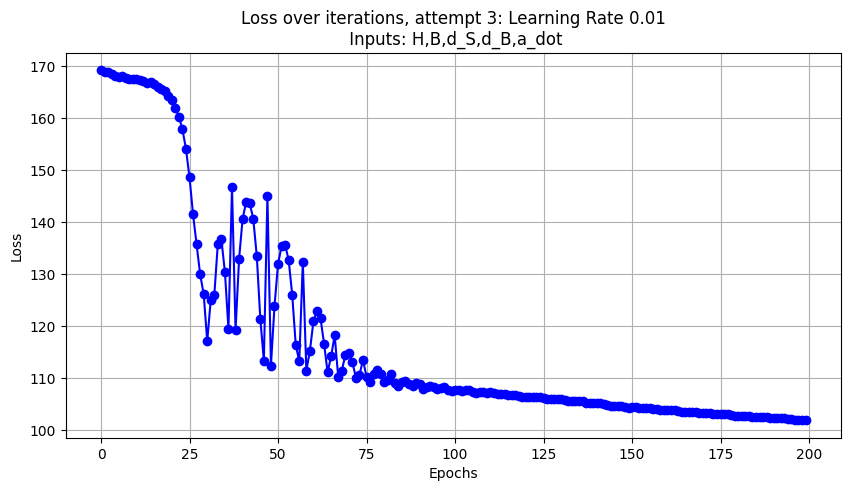

In [17]:
import matplotlib.pyplot as plt

# Plotting the loss list
plt.figure(figsize=(10, 5))
plt.plot(loss_list3, marker='o', linestyle='-', color='b')
plt.title('Loss over iterations, attempt 3: Learning Rate '+ str(learning_rate3) +'\n Inputs: H,B,d_S,d_B,a_dot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [23]:
torch.save(mlp3,(f'{path}/model_saves/mlp3.pt'))

In [38]:
mlp_loaded = torch.load(f'{path}/model_saves/mlp3.pt')

In [49]:
# assign points (x,y) for variable checking
point_fall    = (-0.05391,0.14211)
point_terminus= (0.23102,-0.11072)

array(0.3127592)

In [76]:
# point_fall, directly above the ice fall
B_grad_tensor = torch.linalg.norm(torch.tensor(B_grad(point_fall)))
S_grad_tensor = torch.linalg.norm(torch.tensor(S_grad(point_fall)))

print('Point just before the ice fall')
print('B:      ',B_f(point_fall))
print('adot:   ',adot_f(point_fall))
print('H:      ',H_f(point_fall))
print('B_grad: ',B_grad_tensor.item())
print('S_grad: ',S_grad_tensor.item())

Point just before the ice fall
B:       0.31275920031002424
adot:    0.00015540125786550981
H:       0.009422017050310653
B_grad:  4.282311122587403
S_grad:  3.2483922290298466


In [108]:
# point_terminus, near the front of the glacier
B_grad_tensor = torch.linalg.norm(torch.tensor(B_grad(point_terminus)))
S_grad_tensor = torch.linalg.norm(torch.tensor(S_grad(point_terminus)))

print('Point near the terminus')
print('B:      ',B_f(point_terminus))
print('adot:  ' ,adot_f(point_terminus))
print('H:      ',H_f(point_terminus))
print('B_grad: ',B_grad_tensor.item())
print('S_grad: ',S_grad_tensor.item())

Point near the terminus
B:       0.017005289305522357
adot:   -0.0007150204551678946
H:       0.01524554419785896
B_grad:  0.6070327200847287
S_grad:  0.35396208977772375


In [119]:
# extremes

B_min      = B_f.dat.data[:].min()
B_max      = B_f.dat.data[:].max()
adot_min   = adot_f.dat.data[:].min()
adot_max   = adot_f.dat.data[:].max()
H_min      = H_f.dat.data[:].min()
H_max      = H_f.dat.data[:].max()
B_grad_min = B_grad.dat.data[:].min()
B_grad_max = B_grad.dat.data[:].max()
S_grad_min = S_grad.dat.data[:].min()
S_grad_max = S_grad.dat.data[:].max()